In [12]:
import sys
import os
sys.path.append("../..")

from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.datasets.BrightSpotsSDOML import BrightSpotsSDOMLDataset, BrightSpotsSDOMLDataModule 
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
from importlib import reload
from sdofm.models import unet


In [3]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [4]:
data_module = BrightSpotsSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 4,
    num_workers = 14,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2011-01-01',
    end_date   = '2014-12-31',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [21]:
reload(unet)
channel_to_predict = 6
model = unet.UNet(n_channels=12, n_classes=1, bilinear=True, use_embeddings_block=False, size_factor=4)
self = model
model_name = f"unetmodel_{self.n_channels}ch_{self.n_classes}classes_{'bilinear' if self.bilinear else 'notbilinear'}_sizefactor{self.size_factor}"
model_name

'unetmodel_12ch_1classes_bilinear_sizefactor4'

In [22]:
dataloader = data_module.train_dataloader()
vizdl = dataloader
viz_iter = iter(vizdl)

In [25]:
batch = next(viz_iter)
modelcpu = model.cpu()
image_stack = batch['image_stack']
bright_spots = batch['bright_spots']
pred = modelcpu(image_stack)
image_stack.sum()

fw


tensor(-497513.5000)

fw


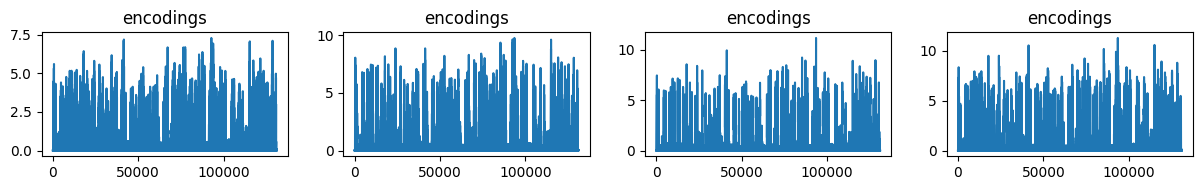

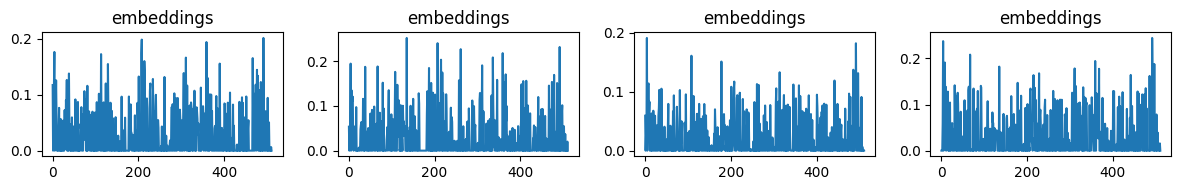

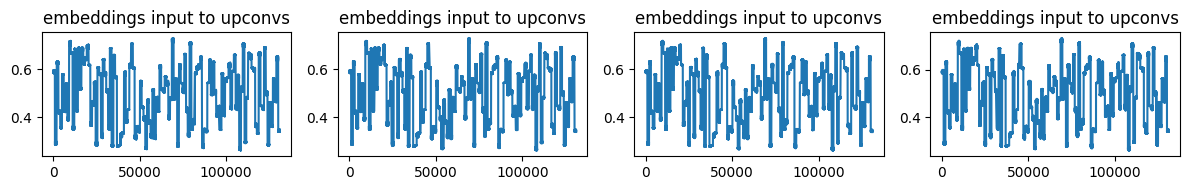

In [26]:
reload(unet)
model = torch.load(f"{model_name}.ckpt").cpu()
enc = model.forward_encode(image_stack)
emb = model.forward_to_embeddings(enc)
fwemb = model.forward_from_embeddings(emb)

rfwemb = fwemb.reshape(len(fwemb),-1)
renc   = enc.reshape(len(enc),-1)

for ax,i in subplots(len(renc), usizey=2):
    plt.plot(renc[i].detach().numpy())
    plt.title("encodings")

for ax,i in subplots(len(emb), usizey=2):
    plt.plot(emb[i].detach().numpy())
    plt.title("embeddings")
    
for ax,i in subplots(len(rfwemb), usizey=2):
    plt.plot(rfwemb[i].detach().numpy())
    plt.title("embeddings input to upconvs")
